# Introduction

Usually, crypto seasons are determined based on the highest and lowest price points of a cycle. However, an alternative approach could be to use more stable anchor points, such as halvings. Halvings are significant events in the Bitcoin on-chain ecosystem and occur every 210,000 blocks. It's important to note that the block mining speed can vary over time, resulting in uneven durations between halvings. By replacing the standard time axis with block count, we can establish more precise seasons based on blocks. Subsequently, we can explore extracting seasonality patterns from the historical price movements.

*Data sourced from TradingView.*

# EDA

Installing packages

In [1]:
!pip install tslearn

## Importing libraries

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.special import inv_boxcox
from tslearn.barycenters import softdtw_barycenter

## Importing data

In [3]:
BASE_DIR = os.getcwd()

In [4]:
# INDEX_BTCUSD, 720 - 12h timefame
df = pd.read_csv(f'{BASE_DIR}/datasets/BTC-USD(4).csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    4846 non-null   object 
 1   open    4846 non-null   float64
 2   high    4846 non-null   float64
 3   low     4846 non-null   float64
 4   close   4846 non-null   float64
dtypes: float64(4), object(1)
memory usage: 189.4+ KB


In [5]:
blocks = pd.read_csv(f'{BASE_DIR}/datasets/GLASSNODE_BTC_BLOCKS, 1D.csv')
blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5212 entries, 0 to 5211
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    5212 non-null   object
 1   open    5212 non-null   int64 
 2   high    5212 non-null   int64 
 3   low     5212 non-null   int64 
 4   close   5212 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 203.7+ KB


## Preparing data

The `time` column needs to be converted to the appropriate data type and set as the index.

In [6]:
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(df['time']).drop('time', axis=1)

We will only consider the `close` price and remove other components of the candle for further analysis.

In [7]:
df = df.drop(['open','high','low'], axis=1)
df = df.astype('float')
df_d = df[['close']]

Let's take a look at what we have.

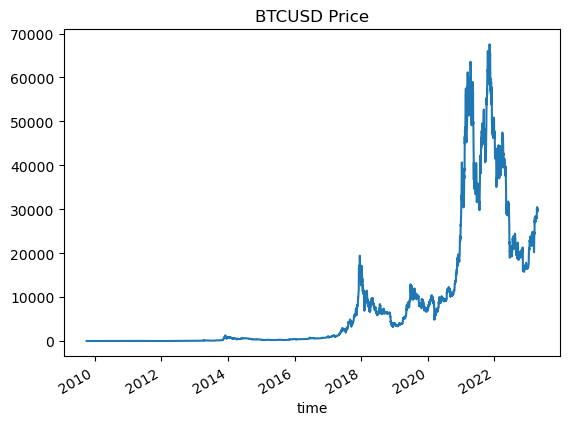

In [8]:
df_d['close'].plot(kind='line', title='BTCUSD Price');

## Replace indexes

Removing unnecessary columns

In [9]:
blocks['time'] = pd.to_datetime(blocks['time'])
blocks = blocks.set_index(blocks['time']).drop('time', axis=1)
blocks = blocks.drop(['open','high','low'], axis=1)
blocks = blocks.astype('float')
blocks['close2'] = blocks['close']
blocks = blocks.drop(['close'], axis=1)

Joining price and ammount of mined blocks by time.

In [10]:
df_b = df.join(blocks, how='inner')
df_b.rename(columns={'close2': 'block'}, inplace=True)
df_b

,close,block
time,,
2009-10-05 00:00:00+00:00,0.000764,24418.0
2009-10-06 00:00:00+00:00,0.000885,24461.0
2009-10-07 00:00:00+00:00,0.001050,24521.0
2009-10-08 00:00:00+00:00,0.001084,24591.0
2009-10-09 00:00:00+00:00,0.001200,24671.0
...,...,...
2023-04-13 00:00:00+00:00,30407.470000,785290.0
2023-04-14 00:00:00+00:00,30495.030000,785430.0
2023-04-15 00:00:00+00:00,30324.640000,785588.0


In [11]:
time_block = df_b.drop('close', axis=1)

Let's look at the changing speed of mining over time.

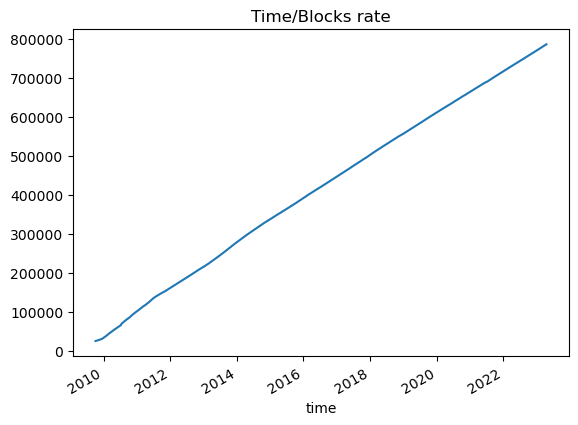

In [12]:
df_b['block'].plot(kind='line', title='Time/Blocks rate');

And finally, replacing of time indexing to block indexing.

In [13]:
df_b.set_index('block', inplace=True)

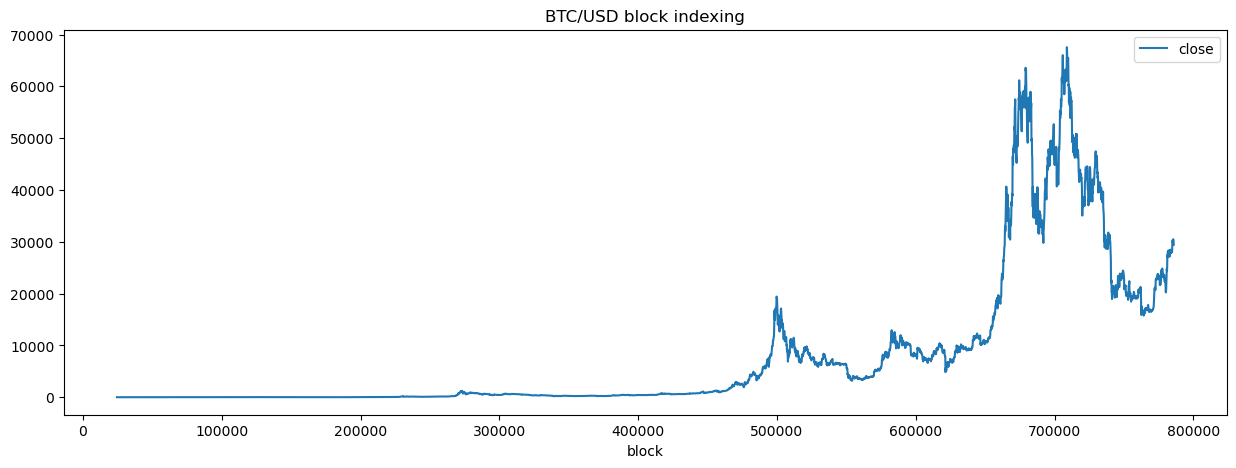

In [14]:
df_b.plot(kind='line', figsize=(15,5), title='BTC/USD block indexing');

In [15]:
df_b

,close
block,
24418.0,0.000764
24461.0,0.000885
24521.0,0.001050
24591.0,0.001084
24671.0,0.001200
...,...
785290.0,30407.470000
785430.0,30495.030000
785588.0,30324.640000


## Box-Cox Transformation

In [16]:
df_box = pd.DataFrame(df_b.copy())
df_box['close'], box_cox_lambda = stats.boxcox(df_b['close'])

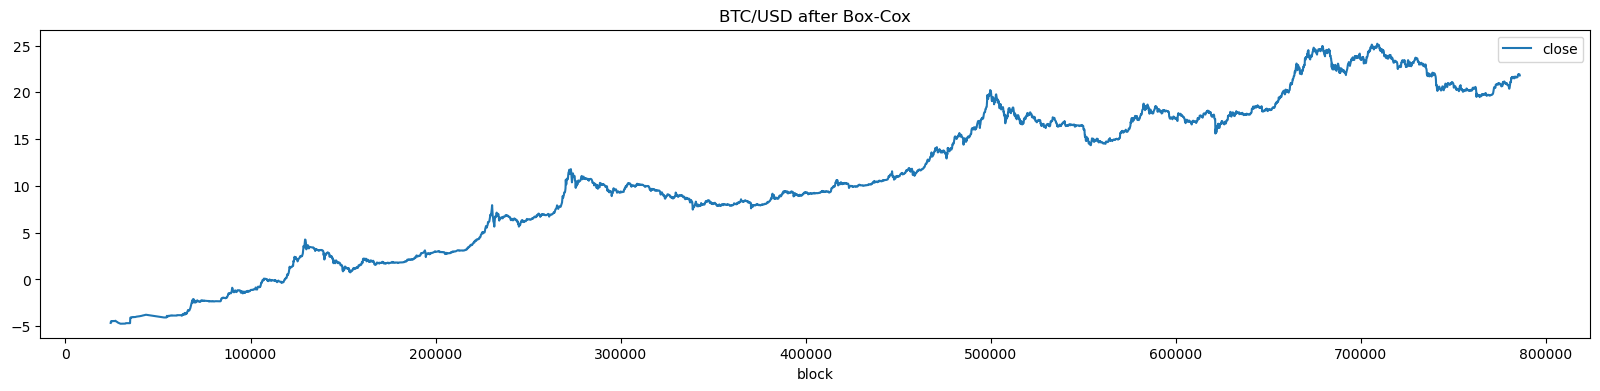

In [17]:
df_box.plot(kind='line', figsize = (20,4), title='BTC/USD after Box-Cox');

In [18]:
box_cox_lambda

0.13134561458013058

## LOWESS (Locally Weighted Scatterplot Smoothing)

LOWESS allows manual extraction of the trend and subtraction of it from the time series.

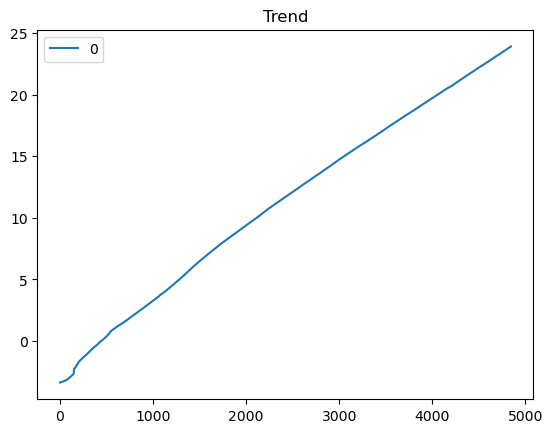

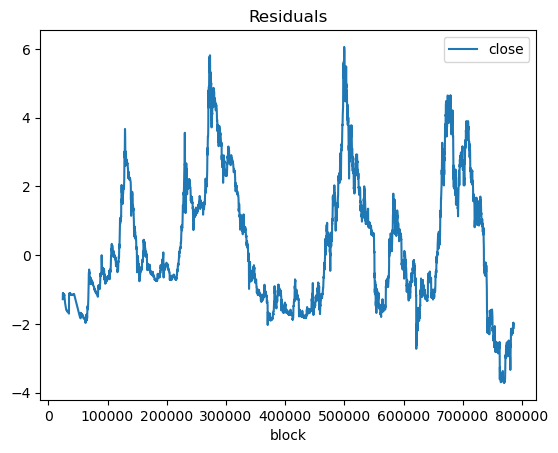

In [19]:
trend = pd.DataFrame(lowess(
    df_box['close'], 
    df_box.index, 
    frac=1, 
    it=4, 
    return_sorted=False
))
trend.plot(kind='line', title='Trend');
trend.set_index(df_box.index, inplace=True)
df_cycle = df_box.copy()
df_cycle['close'] = (df_box['close'] - trend[0])
df_cycle.plot(kind='line', title='Residuals');

Let's check the residuals using the ADF test.

In [20]:
result = adfuller(df_box)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.5885636163616288
p-value: 0.4893358153424497
Critical Values: {'1%': -3.4317096824174698, '5%': -2.862140827434085, '10%': -2.5670898220592187}


The test has passed.

## Filling missing values and resamling

Due to the transition from time-indexing to block-indexing, two issues have appeared:

1. There are many missing values at the beginning of the dataset because block count information is missing in the early BTC history. To fill these gaps, we will use the `bfill` method.

2. Since mining speed is non-linearly dependent on time, the resulting index is non-monotonic. The simplest way to address this is by resampling the time series.

Currently, the history includes 210,000 * 3 + 155,867 blocks. Some information is missing at the beginning, and some blocks are missing at the end of the last cycle because it has not yet completed. To make the series monotonic, we will group the data into larger periods, with each indexing step equal to 1000 blocks.

In [21]:
print(f'Will divide data to {round((210000*3 + 155867)/100)} bins')

Will divide data to 7859 bins


Trim the data to a length that is divisible by 100 without a remainder.

In [22]:
df_cycle = df_cycle[0:785900]

Fill the gaps after detrending the series.

In [23]:
new_row = pd.DataFrame({'close': [None], 'time': [0.0]})
new_row = new_row.set_index('time', drop=True)

df_cycle = pd.concat([new_row, df_cycle], axis=0)


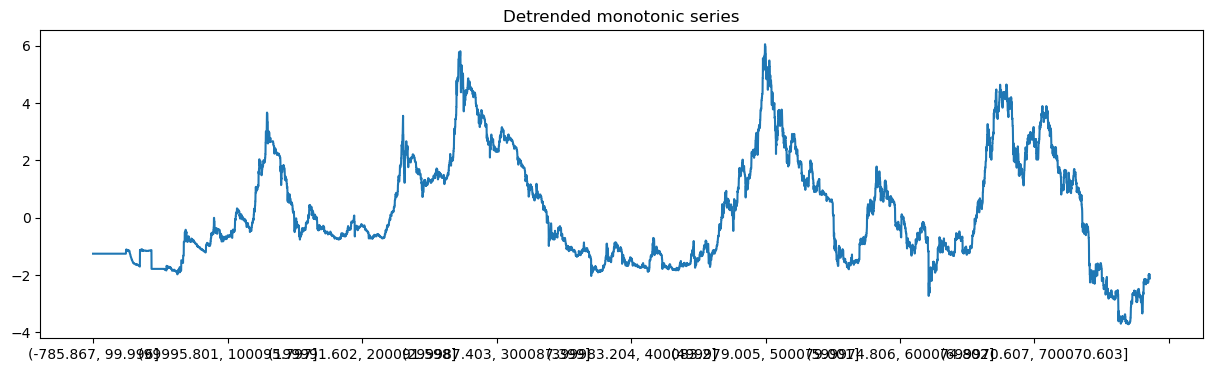

In [24]:
# Divide the data into batches
batches = pd.cut(df_cycle.index, bins=round((785900)/100))

# Grouping values using a mean method
grouped = df_cycle.groupby(batches)['close'].mean()

# Fill 'na' values
grouped = grouped.fillna(method='bfill')
grouped.plot(kind='line', figsize = (15,4), title='Detrended monotonic series');

After making the series monotonic, we can drop the indexes.

In [25]:
df_g = grouped.reset_index(drop=True)
df_g

0      -1.252094
1      -1.252094
2      -1.252094
3      -1.252094
4      -1.252094
          ...   
7854   -1.962241
7855   -1.989343
7856   -1.989343
7857   -1.993430
7858   -2.112057
Name: close, Length: 7859, dtype: float64

## Extraction of a period


First of all, we need to divide the time series into periods corresponding to each halving, which occurs every 210,000 blocks.

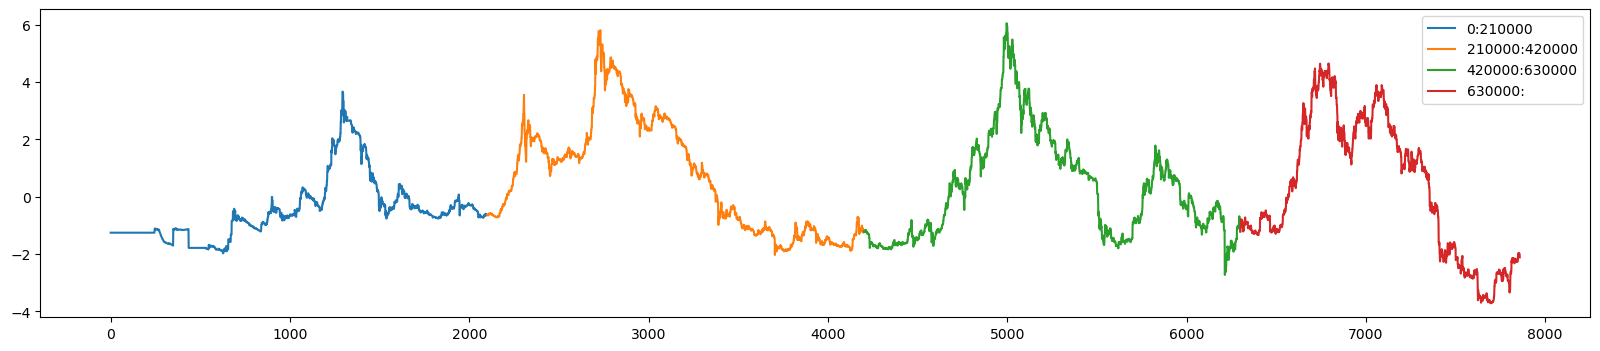

In [26]:
fig, ax = plt.subplots()

df_g[0:2100].plot(kind='line', ax=ax, figsize = (20,4))
df_g[2100:4200].plot(kind='line', ax=ax, figsize = (20,4))
df_g[4200:6300].plot(kind='line', ax=ax, figsize = (20,4))
df_g[6300:].plot(kind='line', ax=ax, figsize = (20,4))

ax.legend(['0:210000', '210000:420000', '420000:630000', '630000:'])
plt.show()


We can observe four periods with a relatively similar structure. Now let's explore a few averaging methods.

To perform the averaging of periods, we need to take a few additional steps.

In [27]:
df_t1 = df_g[0:2100]
df_t1.index = df_t1.index
df_t2 = df_g[2100:4200]
df_t2.index = df_t2.index - 2100
df_t3 = df_g[4200:6300]
df_t3.index = df_t3.index - 4200
df_t4 = df_g[6300:]
df_t4.index = df_t4.index - 6300

In [28]:
df_all = pd.DataFrame(df_t1.copy())
# Dividing weight of first period in a half to decrease it impact to resulting pattern.
df_all['close'] = df_all['close']/2
df_all['close2'] = df_t2
df_all['close3'] = df_t3
df_all['close4'] = df_t4

In [29]:
df_all

,close,close2,close3,close4
0,-0.626047,-0.635795,-1.214298,-1.210226
1,-0.626047,-0.630518,-1.228192,-1.119947
2,-0.626047,-0.630518,-1.228192,-0.944026
3,-0.626047,-0.622380,-1.232683,-0.944026
4,-0.626047,-0.628958,-1.181498,-0.782569
...,...,...,...,...
2095,-0.301442,-1.115117,-0.748354,NaN
2096,-0.317693,-1.115117,-0.844603,NaN
2097,-0.317693,-1.250994,-0.844603,NaN
2098,-0.323044,-1.161726,-1.146170,NaN


To fill in the missing values of the last period, we can use the `ffill` method.

In [30]:
df_mean = df_all.fillna(method='ffill').mean(axis=1)

### Averaging

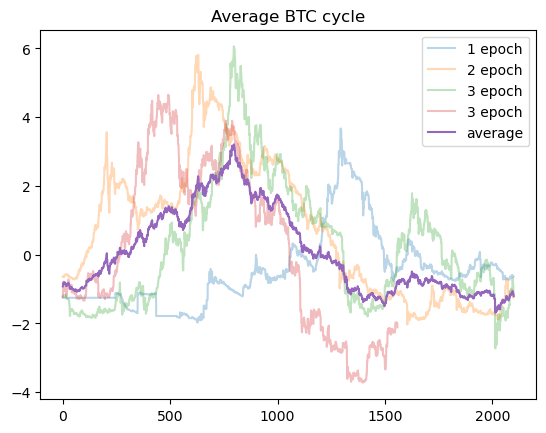

In [31]:
fig, ax = plt.subplots()

df_t1.plot(kind='line', ax=ax, alpha = 0.3)
df_t2.plot(kind='line', ax=ax, alpha = 0.3)
df_t3.plot(kind='line', ax=ax, alpha = 0.3)
df_t4.plot(kind='line', ax=ax, alpha = 0.3)
df_mean.plot(kind='line', ax=ax)

ax.legend(['1 epoch', '2 epoch', '3 epoch', '3 epoch','average'])
plt.title('Average BTC cycle')
plt.show()


### DTW (Dynamic Time Wraping)

This method allows us to obtain an "average" period regardless of the biases in the time series.

c:\Users\danii\anaconda3\lib\site-packages\tslearn\barycenters\softdtw.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_ = numpy.array([to_time_series(d, remove_nans=True) for d in X_])


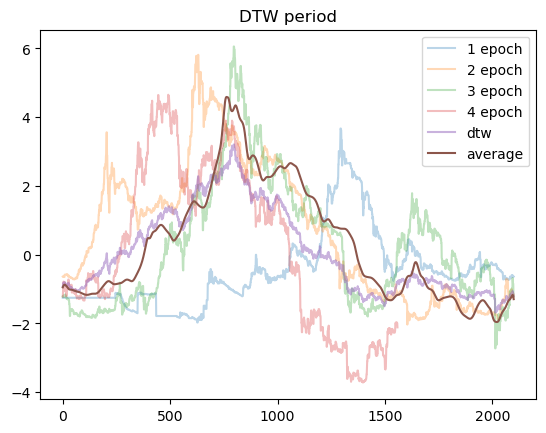

In [32]:
dtw = softdtw_barycenter(
    df_all.transpose(), 
    weights=[0.5,1,1,1], 
    gamma=15, 
    max_iter=500, 
    tol=1e-6,
    method='L-BFGS-B'
)

df_dtw = pd.DataFrame(dtw)

fig, ax = plt.subplots()

df_t1.plot(kind='line', ax=ax, alpha = 0.3)
df_t2.plot(kind='line', ax=ax, alpha = 0.3)
df_t3.plot(kind='line', ax=ax, alpha = 0.3)
df_t4.plot(kind='line', ax=ax, alpha = 0.3)
df_mean.plot(kind='line', ax=ax, alpha = 0.5)
df_dtw.plot(kind='line', ax=ax)

ax.legend([
    '1 epoch', 
    '2 epoch', 
    '3 epoch', 
    '4 epoch', 
    'dtw',
    'average',
])

plt.title('DTW period')
plt.show();

Let's compare both methods.

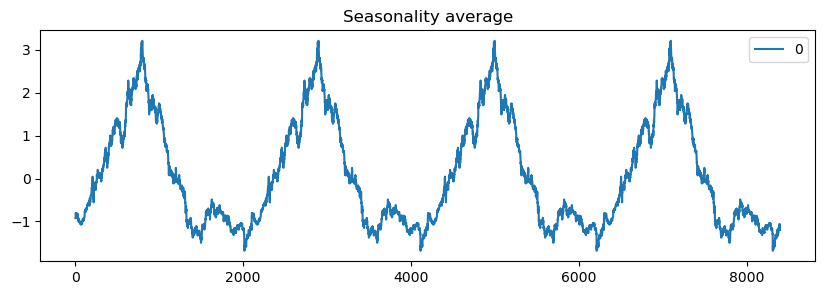

In [33]:
df_mean_full = np.tile(df_mean, 4)
df_mean_full = pd.DataFrame(df_mean_full)[:785900]
df_mean_full.plot(kind = 'line', figsize = (10,3), title='Seasonality average');

Let's subtract seasonality and check residuals for stationarity.

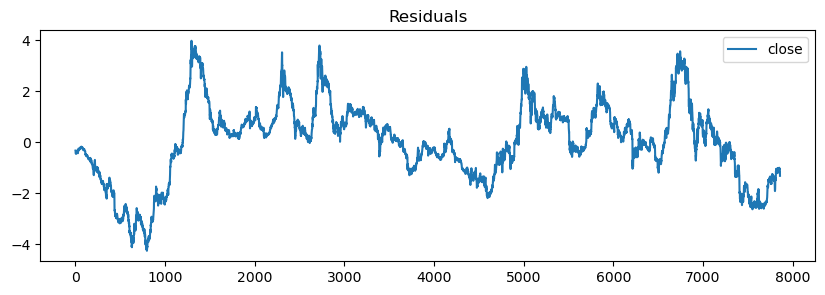

In [34]:
df_mean_full = df_mean_full.rename(columns={0: 'close'})
df_residual = pd.DataFrame(df_g) - df_mean_full
df_residual = df_residual.dropna()
df_residual.plot(kind='line', figsize = (10,3), title='Residuals');

In [35]:
result = adfuller(df_residual)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.5680793286028805
p-value: 0.09977570320167045
Critical Values: {'1%': -3.4311844741213426, '5%': -2.8619087767280904, '10%': -2.5669662952336423}


Based on the results of the Dickey-Fuller test, we can conclude that the series exhibits sufficient statistical significance to reject the null hypothesis of non-stationarity. Therefore, we can consider the series to be stationary.

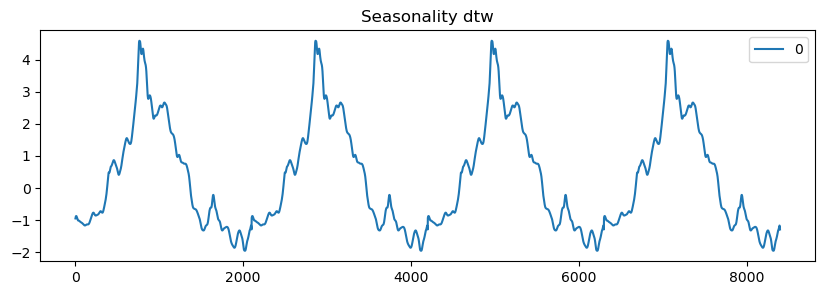

In [36]:
df_dtw_full = np.tile(df_dtw[0], 4)
df_dtw_full = pd.DataFrame(df_dtw_full)[:785900]
df_dtw_full.plot(kind = 'line', figsize = (10,3), title='Seasonality dtw');

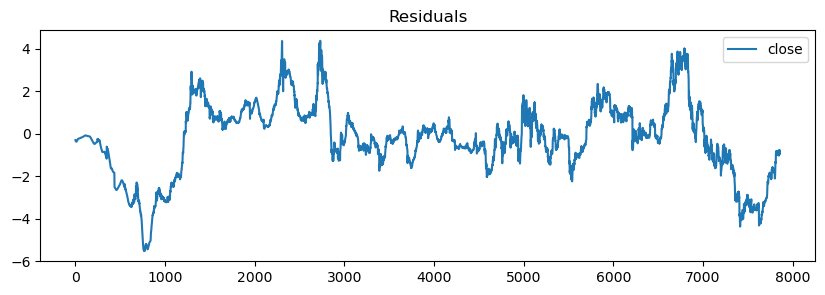

In [37]:
df_dtw_full = df_dtw_full.rename(columns={0: 'close'})
df_residual = pd.DataFrame(df_g) - df_dtw_full
df_residual = df_residual.dropna()
df_residual.plot(kind='line', figsize = (10,3), title='Residuals');

In [38]:
result = adfuller(df_residual)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.8399797401785563
p-value: 0.05278597562550926
Critical Values: {'1%': -3.431183410613548, '5%': -2.8619083068010833, '10%': -2.566966045085996}


# Inverse transformation

In [39]:
df_dtw_full['dtw'] = df_dtw_full['close']
df_dtw_full = df_dtw_full.drop(['close'], axis=1)
df_dtw_full['mean'] = df_mean_full

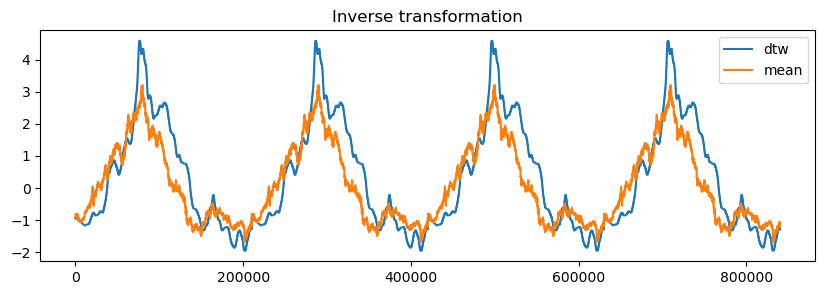

In [40]:
df_back_transformed = df_dtw_full.loc[df_mean_full.index.repeat(100)].reset_index(drop=True)
df_back_transformed.plot(kind='line', figsize=(10, 3), title='Inverse transformation');

## Adding a trend

To add the trend series back to the detrended data, we need to transform the trend series by reversing the Box-Cox transformation and then add it to the detrended data.

In [41]:
# Data preparation
X = trend.index.values.reshape(-1, 1)
y = trend.values

# Creating polynomial features
degree = 2  # Polynomial degree (can be changed to the desired value)
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Training the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Generating new values for extrapolation
X_new = np.arange(0, 840000).reshape(-1, 1)  # New index values

# Applying polynomial features to the new values
X_new_poly = poly_features.transform(X_new)

# Predicting values based on the model
y_new = model.predict(X_new_poly)

# Creating a new DataFrame with extrapolated values
trend_2 = pd.Series(y_new.flatten(), index=X_new.flatten(), name='trend_2')

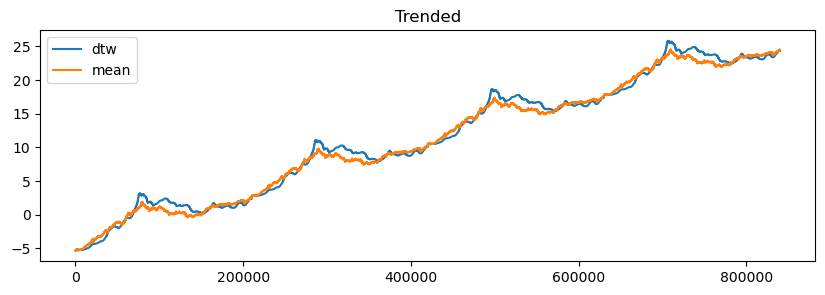

In [42]:
df_trended = df_back_transformed.copy()
df_trended['mean'] = df_back_transformed['mean'] + trend_2
df_trended['dtw'] = df_back_transformed['dtw'] + trend_2
df_trended.plot(kind='line', figsize = (10,3), title='Trended');

## Box-Cox inversed

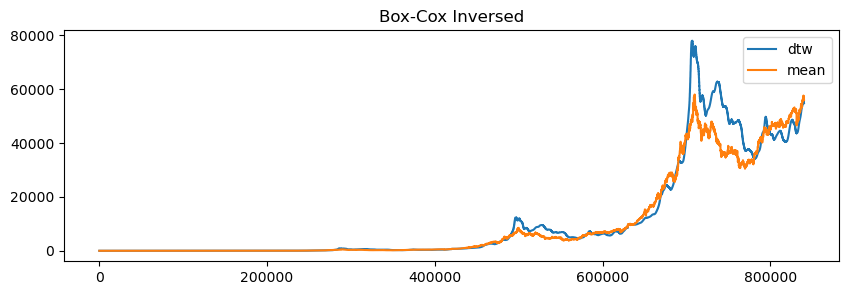

In [43]:
df_box_inverse = pd.DataFrame(df_trended.copy())
df_box_inverse = inv_boxcox(df_trended, box_cox_lambda)
df_box_inverse.plot(kind='line', figsize=(10,3), title='Box-Cox Inversed');

## Returning the time-indexing

In [44]:
time_block['block'] = time_block['block'].astype('int')
time_block['time'] = time_block.index

In [45]:
# Convert the "time" column to a numerical timestamp format
time_block['time'] = pd.to_numeric(pd.to_datetime(time_block['time']))

# Create a new DataFrame with a sequential "block" series with a step of 1
min_block = time_block['block'].min()
max_block = time_block['block'].max()
full_block_range = range(min_block, max_block + 1)
full_df = pd.DataFrame({'block': full_block_range})

# Merge the original DataFrame and the full DataFrame based on the "block" column
merged_df = pd.merge(full_df, time_block, on='block', how='left')

# Linear interpolation to fill missing values in the "time" column
merged_df['time'] = merged_df['time'].interpolate(method='linear')

# Output the final DataFrame with the restored values
print(merged_df)

         block          time
0        24418  1.254701e+18
1        24419  1.254703e+18
2        24420  1.254705e+18
3        24421  1.254707e+18
4        24422  1.254709e+18
...        ...           ...
761445  785863  1.681687e+18
761446  785864  1.681688e+18
761447  785865  1.681688e+18
761448  785866  1.681689e+18
761449  785867  1.681690e+18

[761450 rows x 2 columns]


In [46]:
merged_df = merged_df.set_index(merged_df['block']).drop(['block'], axis=1)

In [47]:
# Data preparation
X = merged_df.index.values.reshape(-1, 1)
y = merged_df.values

# Create polynomial features
degree = 2  # Polynomial degree (can be changed to the desired value)
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Train the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Generate new values for extrapolation
X_new = np.arange(0, 840000).reshape(-1, 1)  # New index values

# Apply polynomial features to the new values
X_new_poly = poly_features.transform(X_new)

# Predict values based on the model
y_new = model.predict(X_new_poly)

In [48]:
merged_df = pd.Series(y_new.flatten(), index=X_new.flatten(), name='time')
merged_df = pd.DataFrame(merged_df)
merged_df['time'] = pd.to_datetime(merged_df['time'])
merged_df

,time
0,2009-05-30 11:43:40.270550272
1,2009-05-30 11:52:04.040855552
2,2009-05-30 12:00:27.811301632
3,2009-05-30 12:08:51.581888512
4,2009-05-30 12:17:15.352615936
...,...
839995,2024-05-23 19:23:17.405378048
839996,2024-05-23 19:33:39.376145664
839997,2024-05-23 19:44:01.347053824
839998,2024-05-23 19:54:23.318102784


To join the time and price series by block count, we can merge the two dataframes using the block count as the key. This will align the time and price values based on their corresponding block counts.

In [49]:
df_box_inverse = pd.DataFrame(df_box_inverse)
df_box_inverse

,dtw,mean
0,0.000098,0.000107
1,0.000098,0.000107
2,0.000098,0.000107
3,0.000098,0.000107
4,0.000098,0.000107
...,...,...
839995,54726.680435,55930.623237
839996,54727.099557,55931.050357
839997,54727.518681,55931.477479
839998,54727.937808,55931.904604


In [50]:
merged_df['mean'] = df_box_inverse['mean']
merged_df['dtw'] = df_box_inverse['dtw']
merged_df

,time,mean,dtw
0,2009-05-30 11:43:40.270550272,0.000107,0.000098
1,2009-05-30 11:52:04.040855552,0.000107,0.000098
2,2009-05-30 12:00:27.811301632,0.000107,0.000098
3,2009-05-30 12:08:51.581888512,0.000107,0.000098
4,2009-05-30 12:17:15.352615936,0.000107,0.000098
...,...,...,...
839995,2024-05-23 19:23:17.405378048,55930.623237,54726.680435
839996,2024-05-23 19:33:39.376145664,55931.050357,54727.099557
839997,2024-05-23 19:44:01.347053824,55931.477479,54727.518681
839998,2024-05-23 19:54:23.318102784,55931.904604,54727.937808


In [51]:
# Round dates
merged_df['time'] = merged_df['time'].dt.floor('D')

# Group data by date
merged_df = merged_df.groupby('time').last().reset_index()
merged_df = merged_df.set_index(merged_df['time']).drop(['time'], axis=1)
merged_df

,mean,dtw
time,,
2009-05-30,0.000108,0.000099
2009-05-31,0.000137,0.000113
2009-06-01,0.000165,0.000125
2009-06-02,0.000143,0.000133
2009-06-03,0.000159,0.000137
...,...,...
2024-05-19,57631.356395,56115.867319
2024-05-20,57146.975712,55917.985396
2024-05-21,56748.145416,55640.043755


## Evaluating of the final result

Plot and compare historical data and both averaged cycles and DTW cycles.

# Conclusion

An investigation was conducted into the price of Bitcoin and its dependence on the cycles that occur after halvings. The analysis utilized the time series decomposition method to separate the data into seasonality, trend, and residuals. Additionally, the application of the Box-Cox transformation aimed to enhance accuracy. To assess the cycles effectively, a transition from time-based indexing to block-based indexing was implemented. Consequently, two variants of cycles were derived: the averaged cycle and the Dynamic Time Warping (DTW) cycle. The averaged cycle offers insights into timing and overall trend, while the DTW method demonstrates potential target levels.

The analysis reveals a three-phase structure of the cycles: growth, decline, and accumulation. Notably, all halvings nearly converged at a single point after detrending and applying the Box-Cox transformation. This observation enables a reasonably accurate price forecast for the next halving when the transformation is reversed. However, it is important to acknowledge that this study is not suitable for direct price predictions but rather serves as a feature for model training.

In conclusion, this project highlights the correlation between Bitcoin's price and post-halving cycles. It underscores the significance of considering multiple factors and methodologies in the analysis and forecasting of cryptocurrency prices. It is crucial to understand that this study provides valuable insights but should be complemented with other approaches to develop robust predictive models.